# LSTM em Veículos Combustão e Elétrico

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

SEED = 42

import warnings
warnings.filterwarnings("ignore")

## Datasets

### Combustão

In [5]:
df_comb = pd.read_csv("./data/combustion_clean.csv", sep=",")
df_comb.head()

,Unnamed: 0,Speed (OBD)(km/h),Absolute Throttle Position B(%),Torque(Nm),CO2_emission_g_per_km
0,30,26.0,14.509804,13.938316,150.638715
1,31,27.0,16.078432,7.000541,145.353899
2,32,27.0,16.862745,7.000541,145.353899
3,33,29.0,16.862745,13.678993,172.692135
4,34,31.0,17.254902,14.091927,169.936145


In [6]:
n = len(df_comb)
n

2831

In [7]:
X_comb = df_comb[['Speed (OBD)(km/h)', 'Absolute Throttle Position B(%)', 'Torque(Nm)']].values
y_comb = df_comb['CO2_emission_g_per_km'].values

### Elétrico

In [8]:
df_elet = pd.read_csv("./data/electric_clean.csv", sep=",")
df_elet.head()

,Unnamed: 0,Velocity [km/h],Throttle [%],Motor Torque [Nm],CO2_emission_g_per_km
0,69,3.47,20.26,6.38,14.977837
1,87,5.80,22.40,19.86,14.693897
2,88,5.88,22.40,16.76,13.213593
3,89,5.94,22.73,14.76,11.965069
4,90,6.00,22.90,11.24,11.093950


In [9]:
len(df_elet)

197493

In [10]:
# Ele pega um sample do dataset elétrico para os dois terem o mesmo número de registros. 
# Ele faz isso pq ele vai juntar os dois datasets lateralmente
df_elet_sample = df_elet.sample(n=len(df_comb), random_state=SEED)
X_elet = df_elet_sample[['Velocity [km/h]', 'Throttle [%]',	'Motor Torque [Nm]']].values
y_elet = df_elet_sample['CO2_emission_g_per_km'].values

### Juntando Lateralmente

In [11]:
# Juntando lateralmente
X = np.concatenate((X_comb, X_elet), axis=1)
X.shape

(2831, 6)

In [12]:
# Juntando verticalmente
# Tem um problema aqui. Ele concatena na horizontal as entradas, mas os rótulos na vertical.
y = np.concatenate((y_comb, y_elet), axis=0)
y.shape

(5662,)

In [13]:
y.reshape(-1, 1).shape

(5662, 1)

## Normalização

In [14]:
# Ele escolheu a normalização min-max, mas poderia ter sido outra.
# Tem que testar os resultados com e sem essa normalização. Assim como com outras normalizações.
# Eu tenho um notebook com os normalizadores já
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

## Treinamento Dos Modelos

In [61]:
def LSTM_model(X_train, X_test, y_train, y_test, epochs=10):
    # Reshape
    # X_train tem inicialmente 2264 linhas e 3 colunas
    # Depois do reshape, ela tem 2264 linhas, 1 coluna e 3 profundidades
    # Essa 1 coluna era para ser o tamanho da janela do LSTM.
    # No caso, ele está usando a janela de 1, não tem janela.
    # Para aumentar a janela, não basta apenas mexer nesse 1, tem que fazer um for e ir agrupando de tantos em tantos
    # Exemplo: https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/ no step 3
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Arquitetura do modelo LSTM - (Rede neural que leva em consideração uma janela de tempo)
    # Poderia usar uma arquitetura diferente. Eu vi um exemplo que usa LSTM, dropout, lstm, dropout e dense.
    model = tf.keras.Sequential(
        [
            # Input layer não está descrito aqui. Está implícito
            tf.keras.layers.LSTM(32, activation='tanh', input_shape=(1, X_train.shape[2])), # Layer que é o LSTM
            tf.keras.layers.Dense(32, activation='relu'), # Hidden layer 
            tf.keras.layers.Dense(1) # Output layer com um neurônio para a regressão
        ]
    )

    # Compilando
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Treinando
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)

    # Gráfico do treinamento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    # Evaluation
    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

### Combustão

In [16]:
# Ele faz algo meio surreal, ainda não sei se tem uma lógica mais pra frente
# Ele está trabalhando com 2 datasets, um de combustão e outro elétrico
# Cada um deles tem uma parte X de entradas e uma y do rótulo.
# Ele junta lateralmente as duas partes X, sendo as colunas 0, 1 e 2 (:3) equilvalente as colunas de combustão
# As demais colunas a partir da terceira (3:) são as do carro elétrico

# Ao mesmo tempo, ele pega o menor dataset e faz um sample do outro para os dois ficarem do mesmo tamanho
# Em seguida ele concatena verticalmente. Então da linha 0 até o tamanho (n) é o de combustão.
# De n até o final é o de elétrico.

# Para que ele embola tudo eu ainda não sei.
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_scaled[:, :3], y_scaled[:n, 0], test_size=0.2, random_state=SEED)

I0000 00:00:1741877300.673369   37136 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6245 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


I0000 00:00:1741877302.182288   37485 cuda_dnn.cc:529] Loaded cuDNN version 90300


142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1473 - mae: 0.3158 - val_loss: 0.0216 - val_mae: 0.1028
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - mae: 0.0946 - val_loss: 0.0089 - val_mae: 0.0677
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - mae: 0.0634 - val_loss: 0.0072 - val_mae: 0.0553
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0551 - val_loss: 0.0065 - val_mae: 0.0535
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - mae: 0.0565 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0549 - val_loss: 0.0058 - val_mae: 0.0508
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0551 - val_loss: 0.0059 - val_mae: 0.0544
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - mae: 0.0541 - val_loss: 0.0054 - val_mae: 0.0498
Epoch 9/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 

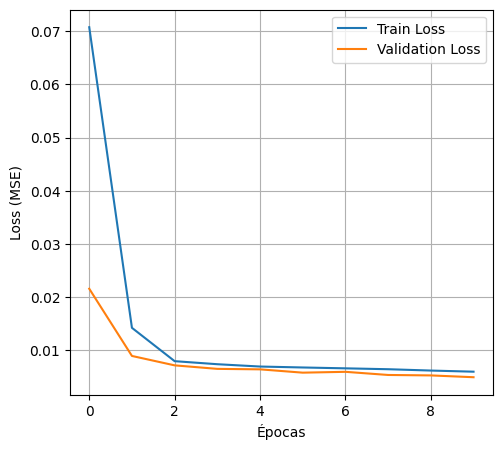

In [17]:
model_LSTM_comb = LSTM_model(X_train_comb, X_test_comb, y_train_comb, y_test_comb)

In [18]:
model_LSTM_comb.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,093 (66.77 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,396 (44.52 KB)

### Elétrico

In [43]:
# Para entender como ele passou os datasets, olhar os comentários na parte de combustão
X_train_elet, X_test_elet, y_train_elet, y_test_elet = train_test_split(X_scaled[:, 3:], y_scaled[n:, 0], test_size=0.2, random_state=SEED)

In [59]:
X_train_elet.reshape((X_train_elet.shape[0], 1, X_train_elet.shape[1]))[0][0]

array([0.38370544, 0.48418679, 0.16346066])

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3585e-05 - mae: 0.0049 - val_loss: 1.2459e-05 - val_mae: 0.0021
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8997e-05 - mae: 0.0028 - val_loss: 1.2641e-05 - val_mae: 0.0023
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0338e-05 - mae: 0.0027 - val_loss: 1.1907e-05 - val_mae: 0.0020
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9271e-05 - mae: 0.0027 - val_loss: 1.2614e-05 - val_mae: 0.0022
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4859e-05 - mae: 0.0030 - val_loss: 1.1848e-05 - val_mae: 0.0019
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0549e-05 - mae: 0.0028 - val_loss: 1.1926e-05 - val_mae: 0.0020
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8761e-05 - mae: 0.0026 - val_loss: 1.1282e-05 - val_mae: 0.0019
Epoch 8/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9013e-05 - mae: 0.0027 - val_loss: 1.1559e-05 - val_mae:

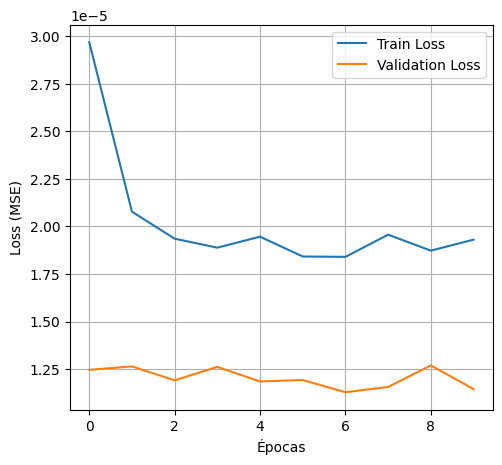

In [20]:
model_LSTM_elet = LSTM_model(X_train_elet, X_test_elet, y_train_elet, y_test_elet)

In [21]:
model_LSTM_elet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,093 (66.77 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,396 (44.52 KB)

## Avaliação

In [22]:
def plot_error_histogram(y_pred, y_test):
    # Erro é o predito menos o real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    plt.show()

### Combustão

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


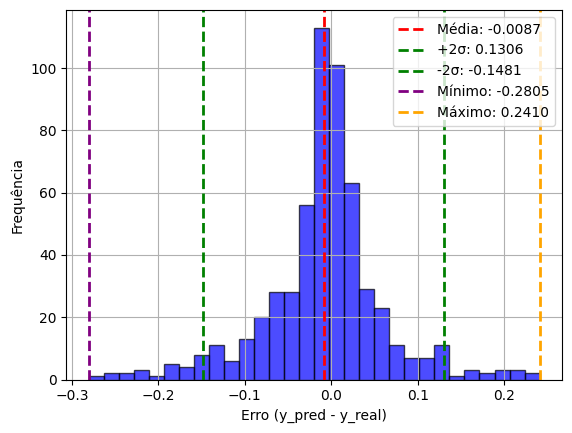

In [26]:
prediction_comb = model_LSTM_comb.predict(X_test_comb.reshape((X_test_comb.shape[0], 1, X_test_comb.shape[1])))
y_pred_comb = prediction_comb.reshape(1,-1)[0]

plot_error_histogram(y_pred_comb, y_test_comb)

### Elétrico

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


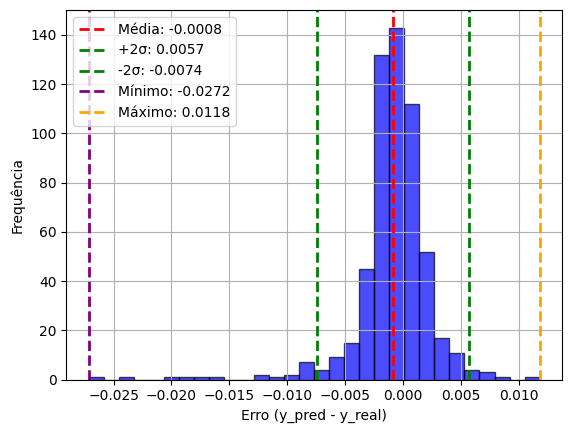

In [29]:
prediction_elet = model_LSTM_elet.predict(X_test_elet.reshape((X_test_comb.shape[0], 1, X_test_elet.shape[1])))
y_pred_elet = prediction_elet.reshape(1,-1)[0]

plot_error_histogram(y_pred_elet, y_test_elet)

## Entradas a Combustão no Modelo do elétrico (Loucura)

In [31]:
X_test_comb.shape

(567, 3)

In [32]:
X_test_comb = X_test_comb.reshape((X_test_comb.shape[0], 1, X_test_comb.shape[1]))
X_test_comb.shape

(567, 1, 3)

In [33]:
# Pq ele está usando os dados de combustão no modelo elétrico???
y_pred_elet = model_LSTM_elet.predict(X_test_comb)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [35]:
# Agora ele uso os dados de combustão com o modelo certo
y_pred_comb = model_LSTM_comb.predict(X_test_comb)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### Desnormalizando

In [36]:
# Está concatenando na vertical os dois Ys. 
# Y de teste da combustão
# Y previsto do elétrico
y_concat = np.concatenate(
    (y_test_comb.reshape(len(y_test_comb), 1), y_pred_elet), 
    axis=0
)

result_pred_inv = scaler_y.inverse_transform(y_concat)

In [37]:
# Novamente ele está fazendo aquela coisa de concatenar os datasets que não tem nada haver para aplicar uma vez só alguma função
# Isso não melhora em nada, apenas dificulta a leitura
y_pred_comb_inv = result_pred_inv[:len(y_test_comb)]
y_pred_elet_inv = result_pred_inv[len(y_test_comb):]

### Comparativo

In [40]:
# Ele escreve uma condição aqui que vai utilizar em todas as fórmulas a seguir.
# Nessa condição ele está pegando apenas os casos que a predição foi maior que zero.
# Na real, não podemos ter uma emissão negativa de CO2
valid_idx = (y_pred_comb_inv > 0) & (y_pred_elet_inv > 0)

# Predito da combustão menos o predito do elétrico. Isso seria a predição da redução de emissões
reducao_absoluta = y_pred_comb_inv[valid_idx] - y_pred_elet_inv[valid_idx]

# Calculando o percentual de redução. (Regra de 3)
reducao_percentual = (reducao_absoluta / y_pred_comb_inv[valid_idx]) * 100

# Estatísticas combustão
media_comb = np.mean(y_pred_comb_inv[valid_idx])
mediana_comb = np.median(y_pred_comb_inv[valid_idx])
desvio_comb = np.std(y_pred_comb_inv[valid_idx])
variancia_comb = np.var(y_pred_comb_inv[valid_idx])
min_comb = np.min(y_pred_comb_inv[valid_idx])
max_comb = np.max(y_pred_comb_inv[valid_idx])
cv_comb = desvio_comb / media_comb * 100  # Coeficiente de variação (%)

# Estatísticas elétrico
media_elet = np.mean(y_pred_elet_inv[valid_idx])
mediana_elet = np.median(y_pred_elet_inv[valid_idx])
desvio_elet = np.std(y_pred_elet_inv[valid_idx])
variancia_elet = np.var(y_pred_elet_inv[valid_idx])
min_elet = np.min(y_pred_elet_inv[valid_idx])
max_elet = np.max(y_pred_elet_inv[valid_idx])
cv_elet = desvio_elet / media_elet * 100  # Coeficiente de variação (%)

# Estatísticas para redução absoluta
media_reducao_absoluta = np.mean(reducao_absoluta)
mediana_reducao_absoluta = np.median(reducao_absoluta)
desvio_reducao_absoluta = np.std(reducao_absoluta)
variancia_reducao_absoluta = np.var(reducao_absoluta)
min_reducao_absoluta = np.min(reducao_absoluta)
max_reducao_absoluta = np.max(reducao_absoluta)
cv_reducao_absoluta = desvio_reducao_absoluta / media_reducao_absoluta * 100  

# Estatísticas para redução percentual
media_reducao_percentual = abs(np.mean(reducao_percentual))
mediana_reducao_percentual = abs(np.median(reducao_percentual))
desvio_reducao_percentual = np.std(reducao_percentual)
variancia_reducao_percentual = np.var(reducao_percentual)
min_reducao_percentual = np.min(reducao_percentual)
max_reducao_percentual = np.max(reducao_percentual)
cv_reducao_percentual = desvio_reducao_percentual / media_reducao_percentual * 100

In [41]:
# Exibir os resultados médios
print(f"🚗 Emissão média (Combustão): {media_comb:.2f} g CO2/km")
print(f"   - Mediana: {mediana_comb:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_comb:.2f}")
print(f"   - Variância: {variancia_comb:.2f}")
print(f"   - Min: {min_comb:.2f} | Max: {max_comb:.2f}\n")


print(f"⚡ Emissão média (Elétrico): {media_elet:.2f} g CO2/km")
print(f"   - Mediana: {mediana_elet:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_elet:.2f}")
print(f"   - Variância: {variancia_elet:.2f}")
print(f"   - Min: {min_elet:.2f} | Max: {max_elet:.2f}\n")


print(f"🔽 Redução média absoluta: {media_reducao_absoluta:.2f} g CO2/km")
print(f"   - Mediana: {mediana_reducao_absoluta:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_reducao_absoluta:.2f}")
print(f"   - Variância: {variancia_reducao_absoluta:.2f}")
print(f"   - Min: {min_reducao_absoluta:.2f} | Max: {max_reducao_absoluta:.2f}\n")


print(f"📉 Redução média percentual: {media_reducao_percentual:.2f}%")
print(f"   - Mediana: {mediana_reducao_percentual:.2f}%")
print(f"   - Desvio padrão: {desvio_reducao_percentual:.2f}")
print(f"   - Variância: {variancia_reducao_percentual:.2f}")
print(f"   - Min: {min_reducao_percentual:.2f}% | Max: {max_reducao_percentual:.2f}%\n")

🚗 Emissão média (Combustão): 141.94 g CO2/km
   - Mediana: 132.42 g CO2/km
   - Desvio padrão: 36.56
   - Variância: 1336.47
   - Min: 71.74 | Max: 260.38

⚡ Emissão média (Elétrico): 6.87 g CO2/km
   - Mediana: 7.17 g CO2/km
   - Desvio padrão: 2.33
   - Variância: 5.44
   - Min: 1.55 | Max: 14.43

🔽 Redução média absoluta: 135.07 g CO2/km
   - Mediana: 125.43 g CO2/km
   - Desvio padrão: 36.42
   - Variância: 1326.55
   - Min: 63.79 | Max: 256.34

📉 Redução média percentual: 94.91%
   - Mediana: 94.71%
   - Desvio padrão: 1.96
   - Variância: 3.83
   - Min: 87.61% | Max: 99.25%



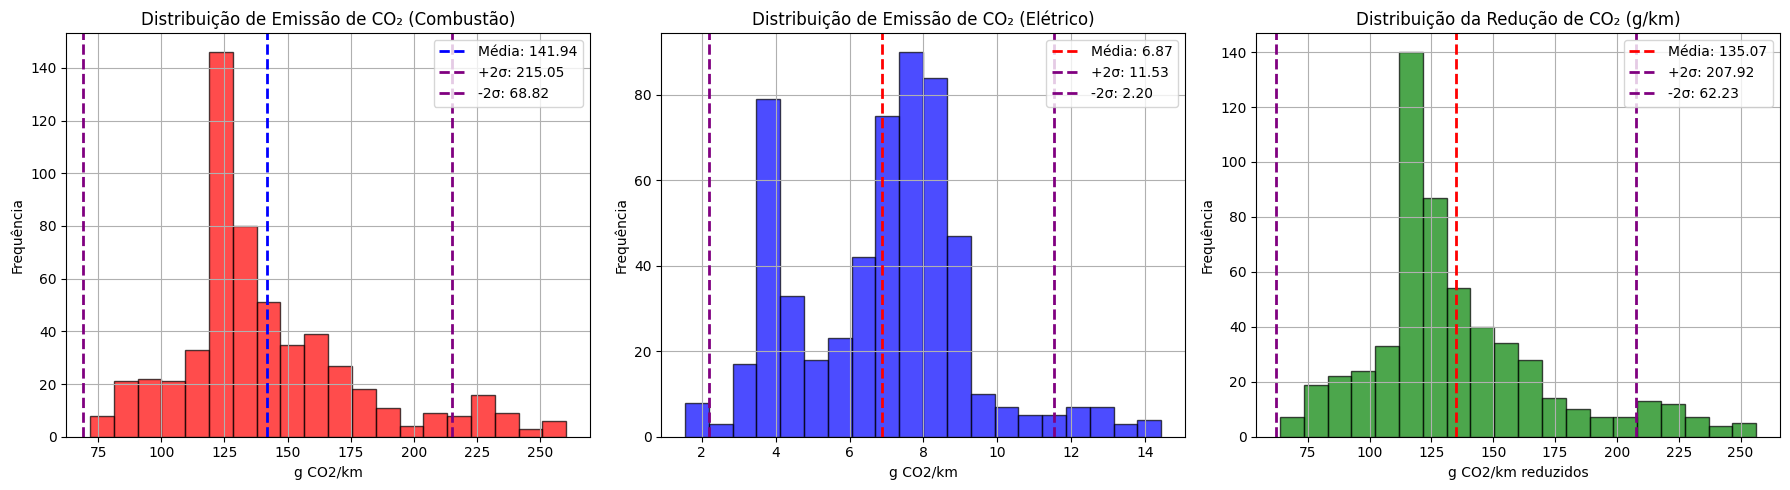

In [42]:
# Previsto para combustão desnormalizado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(y_pred_comb_inv[valid_idx], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0].axvline(media_comb, color='blue', linestyle='dashed', linewidth=2, label=f'Média: {media_comb:.2f}')
axes[0].axvline(media_comb + 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_comb + 2 * desvio_comb):.2f}')
axes[0].axvline(media_comb - 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_comb - 2 * desvio_comb):.2f}')
axes[0].set_title("Distribuição de Emissão de CO₂ (Combustão)")
axes[0].set_xlabel("g CO2/km")
axes[0].set_ylabel("Frequência")
axes[0].grid()
axes[0].legend()

# Previsto para elétrico desnormalizado
axes[1].hist(y_pred_elet_inv[valid_idx], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(media_elet, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_elet:.2f}')
axes[1].axvline(media_elet + 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_elet + 2 * desvio_elet):.2f}')
axes[1].axvline(media_elet - 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_elet - 2 * desvio_elet):.2f}')
axes[1].set_title("Distribuição de Emissão de CO₂ (Elétrico)")
axes[1].set_xlabel("g CO2/km")
axes[1].set_ylabel("Frequência")
axes[1].grid()
axes[1].legend()

# Histograma para redução absoluta
axes[2].hist(reducao_absoluta, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[2].axvline(media_reducao_absoluta, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_reducao_absoluta:.2f}')
axes[2].axvline(media_reducao_absoluta + 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_reducao_absoluta + 2 * desvio_reducao_absoluta):.2f}')
axes[2].axvline(media_reducao_absoluta - 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_reducao_absoluta - 2 * desvio_reducao_absoluta):.2f}')
axes[2].set_title("Distribuição da Redução de CO₂ (g/km)")
axes[2].set_xlabel("g CO2/km reduzidos")
axes[2].set_ylabel("Frequência")
axes[2].grid()
axes[2].legend()

# Ajustar layout
plt.tight_layout()
plt.show()